### Decision trees for predicting heart diseases

#### Arina Sitnikova

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier, export_graphviz

We're taking a [dataset](https://github.com/Yorko/mlcourse.ai/blob/master/data/mlbootcamp5_train.csv) on heart diseases and will try to predict presence or absence of cardiovascular disease.

In [3]:
df = pd.read_csv('mlbootcamp5_train.csv', 
                 index_col='id', sep=';')

In [4]:
df.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
id,,,,,,,,,,,,
0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,17474,1,156,56.0,100,60,1,1,0,0,0,0


We can see that the age is expressed in days. We can tranform the feature to get age in years. Also, we create dummy variables for the cholesterol and gluc variables as there are three categories for each variable.

In [5]:
df['age_years'] = np.floor(df['age'] / 365.25)

In [6]:
chol_dum = pd.get_dummies(df['cholesterol'])
chol_dum.columns = ['chol_1', 'chol_2', 'chol_3']

In [7]:
df = pd.concat([df, chol_dum], axis = 1)

In [8]:
gluc_dum = pd.get_dummies(df['gluc'])
gluc_dum.columns = ['gluc_1', 'gluc_2', 'gluc_3']

In [9]:
df = pd.concat([df, gluc_dum], axis = 1)

In [10]:
df = df.drop(['cholesterol', 'gluc'], axis = 1)

In [11]:
df.head()

,age,gender,height,weight,ap_hi,ap_lo,smoke,alco,active,cardio,age_years,chol_1,chol_2,chol_3,gluc_1,gluc_2,gluc_3
id,,,,,,,,,,,,,,,,,
0,18393,2,168,62.0,110,80,0,0,1,0,50.0,1,0,0,1,0,0
1,20228,1,156,85.0,140,90,0,0,1,1,55.0,0,0,1,1,0,0
2,18857,1,165,64.0,130,70,0,0,0,1,51.0,0,0,1,1,0,0
3,17623,2,169,82.0,150,100,0,0,1,1,48.0,1,0,0,1,0,0
4,17474,1,156,56.0,100,60,0,0,0,0,47.0,1,0,0,1,0,0


Splitting data into train and test parts:

In [12]:
X_train, X_valid, y_train, y_valid = train_test_split(df.drop('cardio', axis = 1), df['cardio'], test_size=0.3,
random_state=17)

Let's try a basic decision tree with max_depth of 3 and visualize it:

In [13]:
tree = DecisionTreeClassifier(max_depth=3, random_state=17)

In [14]:
trees = tree.fit(X_train, y_train)

In [15]:
export_graphviz(trees, out_file='first_tree.dot',
               feature_names=df.drop('cardio', axis = 1).columns, filled=True)

In [16]:
!dot -Tpng first_tree.dot -o first_tree.png

<img src='first_tree.png'>

As we can notice, ap_hi is the most important feature. Age and chol are also used to make predictions.

Let's make predictions for holdout data with the trained decision tree. We get an okay accuracy:

In [17]:
tree_pred = trees.predict(X_valid)

In [18]:
accuracy_score(y_valid, tree_pred)

0.7212857142857143

In [19]:
a1 = accuracy_score(y_valid, tree_pred)

Now let's try to identify the best parameters in order to increase quality of the model. We'll use GridSearchCV for this purpose:

In [20]:
tree_params = {'max_depth': list(range(2, 11))}

tree_grid = GridSearchCV(tree, tree_params, cv = 5)

In [21]:
pred2 = tree_grid.fit(X_train, y_train);

In [22]:
mean_acc = pd.DataFrame(tree_grid.cv_results_.get('mean_test_score'))

In [23]:
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = 10, 6

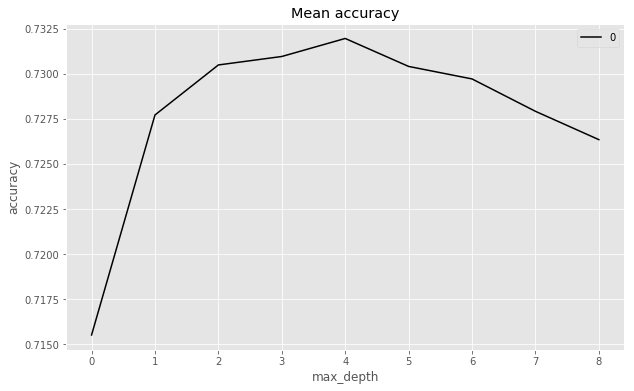

In [24]:
mean_acc.plot(c = 'black', label = 'test');
plt.title("Mean accuracy");
plt.xlabel('max_depth');
plt.ylabel('accuracy');

In [25]:
tree_grid.best_score_, tree_grid.best_params_

(0.7319591836734693, {'max_depth': 6})

Accuracy on the test data:

In [26]:
accuracy_score(y_valid, tree_grid.predict(X_valid))

0.7258095238095238

In [27]:
a2 = accuracy_score(y_valid, tree_grid.predict(X_valid))

We can calculate the effect of GridSearchCV; however, the accuracy increased by less than 1%, which is not a great result.

In [28]:
(a2 - a1)/a1 *100

0.6271869016967002

Let's try to create new features. Cardiovascular disease can greatly depend on the person's age or gender. It's also believed that blood pressure can affect the disease. We decided to create several categories:

In [30]:
df['age4050'] = np.where(((df['age_years']>=40) & (df['age_years'] < 50)) , 1, 0)
df['age5055'] = np.where(((df['age_years']>=50) & (df['age_years'] < 55)) , 1, 0)
df['age5560'] = np.where(((df['age_years']>=55) & (df['age_years'] < 60)) , 1, 0)
df['age6065'] = np.where(((df['age_years']>=60) & (df['age_years'] < 65)) , 1, 0)
df = df.drop('age', axis = 1)

In [31]:
df['aphi12040'] = np.where(((df['ap_hi']>=120) & (df['ap_hi'] < 140)) , 1, 0)
df['aphi14060'] = np.where(((df['ap_hi']>=140) & (df['ap_hi'] < 160)) , 1, 0)
df['aphi16080'] = np.where(((df['ap_hi']>=160) & (df['ap_hi'] < 180)) , 1, 0)

In [32]:
df['male'] = np.where(df['gender'] == 2, 1, 0)

In [33]:
df2 = df.drop(['gender', 'height', 'weight', 'ap_hi', 'ap_lo', 'alco', 'active', 'age_years', 'gluc_1',
              'gluc_2', 'gluc_3'], axis = 1)

In [34]:
df2.head()

,smoke,cardio,chol_1,chol_2,chol_3,age4050,age5055,age5560,age6065,aphi12040,aphi14060,aphi16080,male
id,,,,,,,,,,,,,
0,0,0,1,0,0,0,1,0,0,0,0,0,1
1,0,1,0,0,1,0,0,1,0,0,1,0,0
2,0,1,0,0,1,0,1,0,0,1,0,0,0
3,0,1,1,0,0,1,0,0,0,0,1,0,1
4,0,0,1,0,0,1,0,0,0,0,0,0,0


A new model incorporating all those features was evaluated; however, the accuracy dropped. Thus, we don't need as many categories.

In [35]:
new_tr = DecisionTreeClassifier(random_state = 17, max_depth=3)

In [36]:
X_train, X_valid, y_train, y_valid = train_test_split(df2.drop('cardio', axis = 1), df2['cardio'], test_size=0.3,
random_state=17)

In [37]:
tree2 = new_tr.fit(X_train, y_train)

In [38]:
tree_pred2 = tree2.predict(X_valid)

In [39]:
accuracy_score(y_valid, tree_pred2)

0.704047619047619

In [40]:
export_graphviz(tree2, out_file='sec_tree.dot',
               feature_names=df2.drop('cardio', axis = 1).columns, filled=True)

In [41]:
!dot -Tpng sec_tree.dot -o sec_tree.png

<img src='sec_tree.png'>